# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

> **IMPORTANT NOTE**: This notebook was AI-generated and has not been fully verified. Please exercise caution when interpreting the code or results. Always critically evaluate the outputs and methodologies presented here.

## Overview
This notebook explores Dandiset 001361, which contains 2-photon imaging and behavioral data from hippocampal area CA1 during virtual reality navigation in mice. The dataset is from the study "A flexible hippocampal population code for experience relative to reward" by Sosa, Plitt, & Giocomo published in Nature Neuroscience.

You can access the Dandiset directly here: [https://dandiarchive.org/dandiset/001361/0.250406.0045](https://dandiarchive.org/dandiset/001361/0.250406.0045)

In this notebook, we will:
1. Explore the structure of the Dandiset
2. Load and examine behavioral data from the virtual navigation task
3. Visualize and analyze calcium imaging data from hippocampal neurons
4. Investigate how neural activity relates to behavioral variables like position and rewards

## Required Packages

This notebook requires several Python packages for working with NWB files and visualizing data:
- pynwb - For working with NWB files
- h5py - For working with HDF5 files (the underlying format of NWB)
- remfile - For streaming remote files
- numpy - For numerical operations
- matplotlib - For plotting and visualization
- pandas - For data manipulation and analysis
- seaborn - For enhanced visualizations

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import remfile
import pynwb
import seaborn as sns

# Set the plotting style
sns.set_theme()

## Loading the Dandiset

We can load data from the DANDI archive using the DANDI API. This allows us to connect to the archive and download specific assets from the Dandiset.

In [2]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001361", "0.250406.0045")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description'][:500]}...")  # Show only a portion of the description

# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: A flexible hippocampal population code for experience relative to reward
Dandiset URL: https://dandiarchive.org/dandiset/001361/0.250406.0045
Description: 2-photon imaging and behavioral data from hippocampal area CA1 during virtual reality navigation in mice. Included in Sosa, Plitt, & Giocomo, "A flexible hippocampal population code for experience relative to reward," Nature Neuroscience.

To reinforce rewarding behaviors, events leading up to and following rewards must be remembered. Hippocampal place cell activity spans spatial and non-spatial episodes, but whether hippocampal activity encodes entire sequences of events relative to reward is u...

First 5 assets:
- sub-m11/sub-m11_ses-05_behavior+ophys.nwb (ID: a22cc1da-b5e8-4fea-a770-7b83a6e79656)
- sub-m11/sub-m11_ses-04_behavior+ophys.nwb (ID: b53ef825-89ca-483e-abeb-b38a0ae9293c)
- sub-m11/sub-m11_ses-07_behavior+ophys.nwb (ID: 27481b95-aeb2-4108-b7ac-b3859892da7a)
- sub-m11/sub-m11_ses-06_behavior+ophys.nwb (ID:

## Loading and Examining an NWB File

Let's select one NWB file from the Dandiset and explore its contents. We'll use the URL for a specific asset to load the NWB file using PyNWB.

In [3]:
# URL for a specific NWB file (from the first subject, session 3)
url = "https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/"

# Load the NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the NWB file
print(f"Session ID: {nwb.session_id}")
print(f"Experiment description: {nwb.session_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject species: {nwb.subject.species}")
print(f"Session start time: {nwb.session_start_time}")
print(f"File creation date: {nwb.file_create_date[0]}")

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Session ID: 03
Experiment description: processed suite2p data
Subject ID: m11
Subject sex: M
Subject species: Mus musculus
Session start time: 2023-02-23 00:00:00-08:00
File creation date: 2025-03-12 23:45:29.830157-07:00


## NWB File Structure

Below is a summary of the key components in this NWB file:

### Acquisition
- **TwoPhotonSeries**: Raw calcium imaging data from two-photon microscopy

### Processing Modules
1. **behavior**: Contains behavioral data
   - BehavioralTimeSeries
     - position: Animal's position in the virtual environment
     - speed: Animal's movement speed
     - reward_zone: Binary indicators of when the animal is in a reward zone
     - Reward: Timestamps of reward delivery
     - lick: Licking behavior
     - trial_number: Identifies which trial each timepoint belongs to
     - trial_start: Marks the start of each trial
     - teleport: Marks when the animal is teleported (e.g., at end of trial)
     - environment: Indicates the virtual environment being used
     - autoreward: Whether rewards were automatically delivered

2. **ophys**: Contains calcium imaging data and related processing
   - Fluorescence: Calcium fluorescence signals from each ROI
   - Deconvolved: Deconvolved spike estimates from fluorescence data
   - Neuropil: Neuropil signals associated with each ROI
   - ImageSegmentation: Information about the ROIs (regions of interest)
     - PlaneSegmentation: 
       - pixel_mask: Defines the pixels belonging to each ROI
       - iscell: Classification of ROIs as cells vs non-cells
   - Backgrounds_0: Background images, including mean image and correlation projection

### Subject
Information about the subject, including ID, species, sex, and age.

## Exploring Behavioral Data

Now let's explore the behavioral data from this experiment. We'll look at:
1. The animal's position in the virtual environment
2. Movement speed
3. Reward zones and reward delivery events
4. Trial structure

In [4]:
# Access behavioral data
behavior_path = '/processing/behavior/BehavioralTimeSeries/'

# Get position data
position_data = h5_file[f'{behavior_path}position/data'][:]
position_timestamps = h5_file[f'{behavior_path}position/timestamps'][:]
position_unit = h5_file[f'{behavior_path}position/data'].attrs['unit']

# Get speed data
speed_data = h5_file[f'{behavior_path}speed/data'][:]
speed_timestamps = h5_file[f'{behavior_path}speed/timestamps'][:]
speed_unit = h5_file[f'{behavior_path}speed/data'].attrs['unit']

# Get reward zone data
reward_zone_data = h5_file[f'{behavior_path}reward_zone/data'][:]
reward_zone_timestamps = h5_file[f'{behavior_path}reward_zone/timestamps'][:]

# Get rewards data
rewards_data = h5_file[f'{behavior_path}Reward/data'][:]
rewards_timestamps = h5_file[f'{behavior_path}Reward/timestamps'][:]
rewards_unit = h5_file[f'{behavior_path}Reward/data'].attrs['unit']

# Get trial number data
trial_numbers_data = h5_file[f'{behavior_path}trial number/data'][:]
trial_numbers_timestamps = h5_file[f'{behavior_path}trial number/timestamps'][:]

# Print basic information about the data
print(f"Position data shape: {position_data.shape}, unit: {position_unit}")
print(f"Speed data shape: {speed_data.shape}, unit: {speed_unit}")
print(f"Reward zone data shape: {reward_zone_data.shape}")
print(f"Rewards data shape: {rewards_data.shape}, unit: {rewards_unit}")
print(f"Trial numbers shape: {trial_numbers_data.shape}")

# Print the range of values for position and speed
print(f"Position range: {np.min(position_data)} to {np.max(position_data)} {position_unit}")
print(f"Speed range: {np.min(speed_data)} to {np.max(speed_data)} {speed_unit}")

# Print how many unique trial numbers we see
unique_trials = np.unique(trial_numbers_data)
print(f"Unique trial numbers: {len(unique_trials)} trials (including {np.sum(unique_trials < 0)} pre-trial periods)")

Position data shape: (20684,), unit: cm
Speed data shape: (20684,), unit: cm/s
Reward zone data shape: (20684,)
Rewards data shape: (69,), unit: mL
Trial numbers shape: (20684,)
Position range: -500.0 to 450.5671911764697 cm
Speed range: -2.0806943614844013 to 76.36132887449953 cm/s
Unique trial numbers: 81 trials (including 1 pre-trial periods)


### Visualizing Position and Speed Data

Let's visualize the animal's movement in the virtual environment.

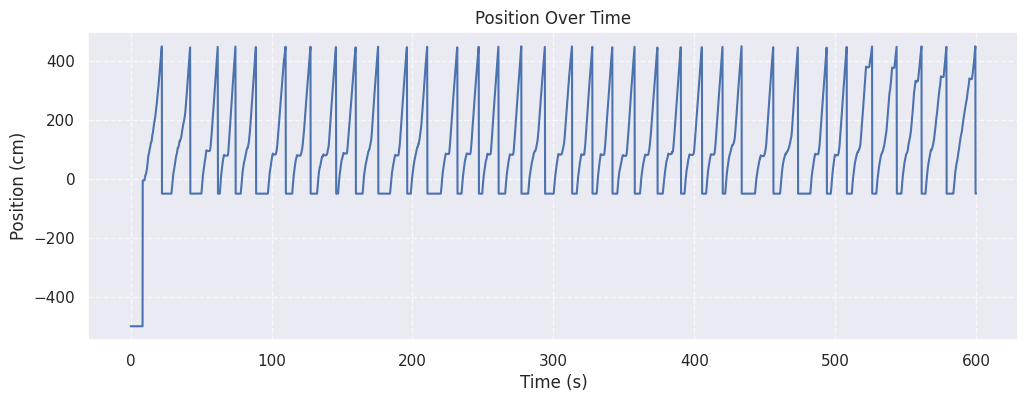

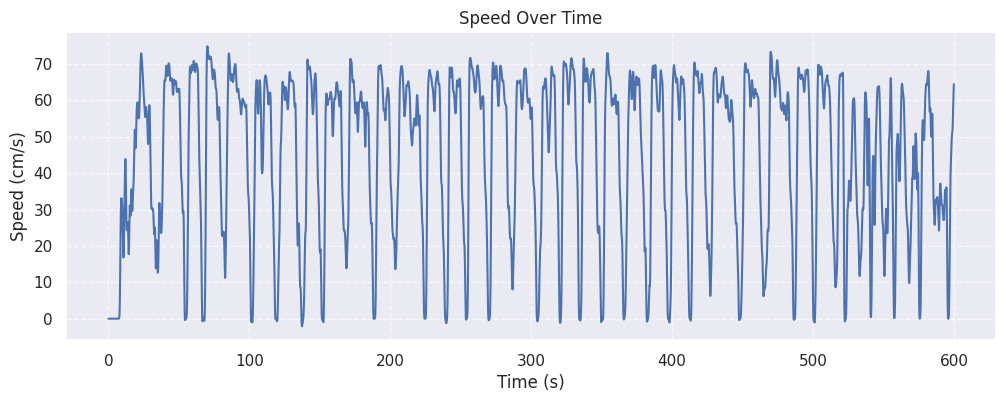

In [5]:
# Select a time window for visualization (first 10 minutes)
time_window = 600  # seconds
time_mask = position_timestamps < time_window

# Plot position over time
plt.figure(figsize=(12, 4))
plt.plot(position_timestamps[time_mask], position_data[time_mask])
plt.xlabel('Time (s)')
plt.ylabel(f'Position ({position_unit})')
plt.title('Position Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot speed over time
plt.figure(figsize=(12, 4))
plt.plot(speed_timestamps[time_mask], speed_data[time_mask])
plt.xlabel('Time (s)')
plt.ylabel(f'Speed ({speed_unit})')
plt.title('Speed Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The position plot shows a repeating pattern of the animal moving through the virtual environment. We can see that:

- The animal navigates from around 0 cm to about 400-450 cm and then teleports back to the start
- This pattern repeats regularly, indicating multiple trials of the task
- The speed data shows that the animal reaches speeds up to 70-80 cm/s during active movement

This pattern is consistent with a linear track virtual reality task, where the animal runs from one end to the other on each trial.

### Reward Zones and Reward Delivery

Now let's look at when the animal enters reward zones and receives rewards.

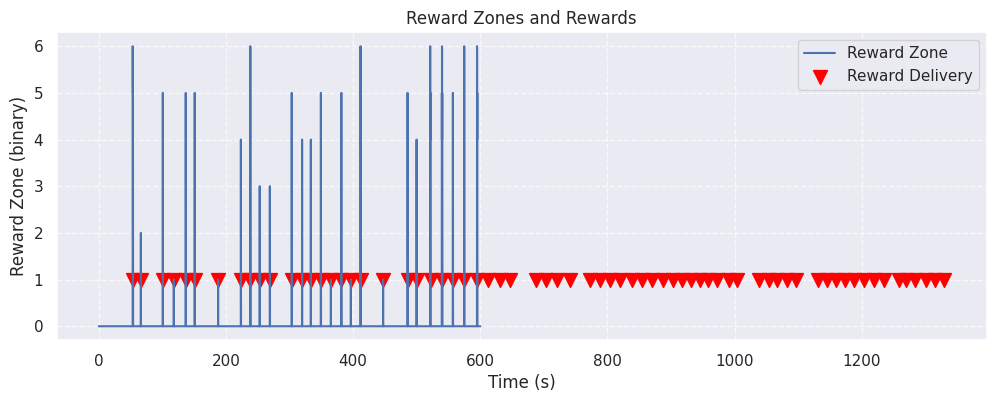

In [6]:
# Plot reward zones and rewards
plt.figure(figsize=(12, 4))
plt.plot(reward_zone_timestamps[time_mask], reward_zone_data[time_mask], label='Reward Zone')
plt.scatter(rewards_timestamps, np.ones_like(rewards_timestamps), 
            color='red', label='Reward Delivery', marker='v', s=100)
plt.xlabel('Time (s)')
plt.ylabel('Reward Zone (binary)')
plt.title('Reward Zones and Rewards')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The plot shows:

- Binary indicators (blue vertical lines) for when the animal enters reward zones
- Red triangles indicating when rewards were delivered
- We can see that rewards are typically delivered when the animal enters a reward zone, indicating a spatial reward task

### Trial Structure

Let's examine the trial structure by looking at how position relates to trial number.

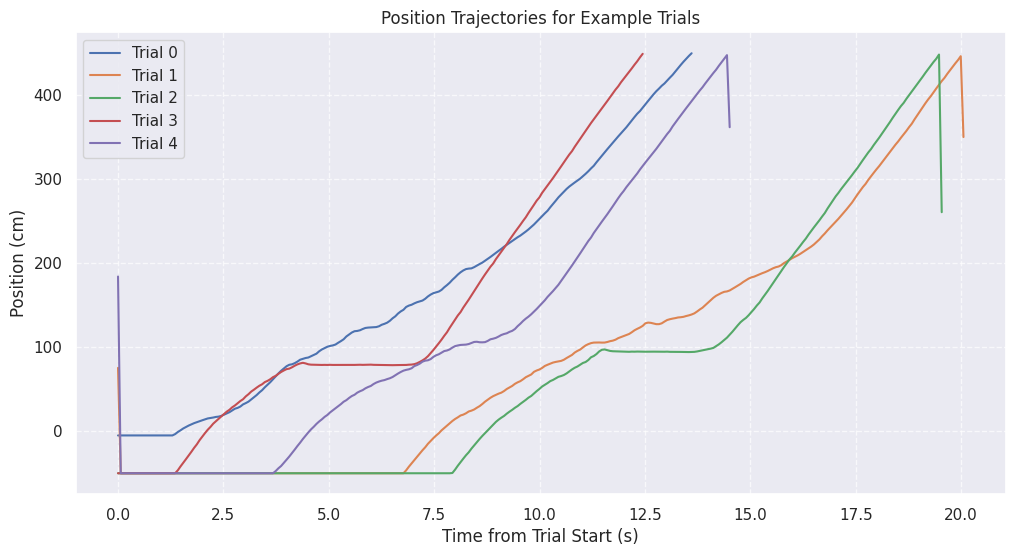

In [7]:
# Plot position trajectories for a few example trials
example_trials = unique_trials[unique_trials >= 0][:5]  # First 5 proper trials
plt.figure(figsize=(12, 6))

for trial in example_trials:
    trial_mask = (trial_numbers_data == trial)
    plt.plot(position_timestamps[trial_mask] - position_timestamps[trial_mask][0], 
             position_data[trial_mask], 
             label=f'Trial {int(trial)}')

plt.xlabel('Time from Trial Start (s)')
plt.ylabel(f'Position ({position_unit})')
plt.title('Position Trajectories for Example Trials')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The trajectory plot shows how the animal's position changes within individual trials. We can observe:

- Different trials have similar overall patterns but show variations in timing and speed
- Trials generally start near position zero and progress to the end of the track
- Some trials show brief pauses or changes in movement speed
- Trial durations vary somewhat, with some trials being completed faster than others

## Exploring Neural Data

Now let's examine the neural data recorded using two-photon calcium imaging. We'll first look at the ROIs (regions of interest) and then explore the calcium signals.

In [8]:
# Access neural data paths
ophys_path = '/processing/ophys/'

# Get information about the ROIs
print("Accessing ROI information...")
roi_table_path = f'{ophys_path}ImageSegmentation/PlaneSegmentation/'

# Get the cell classification (neural ROIs vs non-neural components)
iscell_data = h5_file[f'{roi_table_path}iscell'][:]
print(f"ROI data shape: {iscell_data.shape}")
print(f"Number of ROIs classified as cells: {np.sum(iscell_data[:, 0] > 0.5)}")

# Get a subset of fluorescence data (calcium signals)
time_window_neural = slice(0, 5000)  # Take first 5000 timepoints
neuron_subset = slice(0, None)  # Take all neurons
fluorescence_data = h5_file[f'{ophys_path}Fluorescence/plane0/data'][time_window_neural, neuron_subset]

# Get the sampling rate for the fluorescence data
rate = h5_file[f'{ophys_path}Fluorescence/plane0/starting_time'].attrs['rate']
timestamps_neural = np.arange(fluorescence_data.shape[0]) / rate

# Print basic information about the fluorescence data
print(f"\nFluorescence data shape: {fluorescence_data.shape}")
print(f"Sampling rate: {rate} Hz")
print(f"Recording duration: {timestamps_neural[-1]:.2f} seconds")

Accessing ROI information...
ROI data shape: (349, 2)
Number of ROIs classified as cells: 155



Fluorescence data shape: (5000, 349)
Sampling rate: 15.5078125 Hz
Recording duration: 322.35 seconds


### Visualizing the Mean Image and ROIs

Let's first look at the mean image from the two-photon recordings and visualize some of the ROIs.

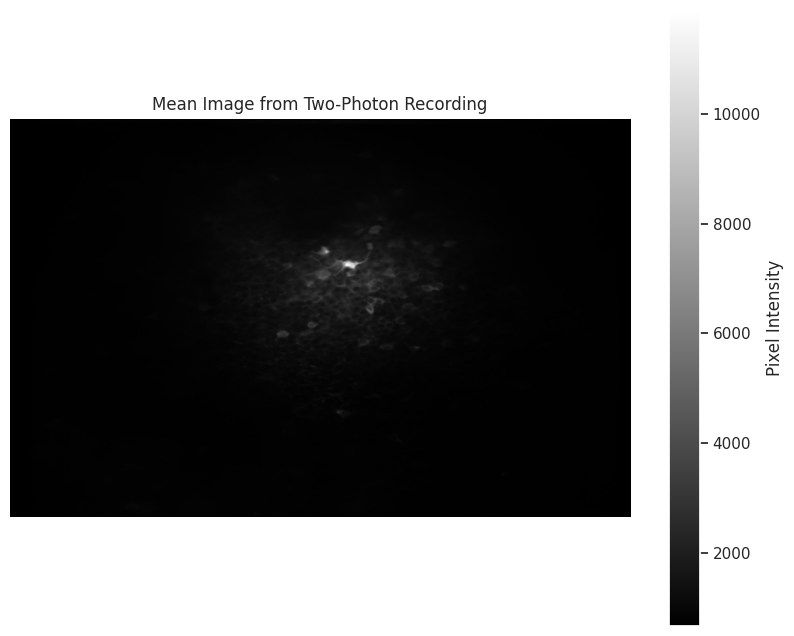

In [9]:
# Get the mean image
mean_img = h5_file[f'{ophys_path}Backgrounds_0/meanImg'][:]

# Plot the mean image
plt.figure(figsize=(10, 8))
plt.imshow(mean_img, cmap='gray')
plt.colorbar(label='Pixel Intensity')
plt.title('Mean Image from Two-Photon Recording')
plt.axis('off')
plt.show()

Now let's visualize some example ROIs on the mean image. We'll overlay several ROIs identified as cells.

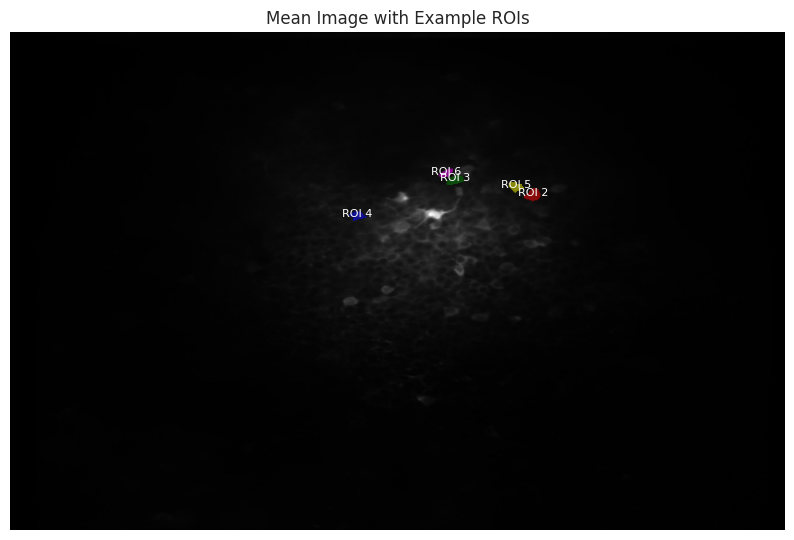

In [10]:
# Access pixel masks for ROIs
pixel_masks = h5_file[f'{roi_table_path}pixel_mask'][:]
pixel_mask_index = h5_file[f'{roi_table_path}pixel_mask_index'][:]

# Function to get pixel masks for a specific ROI
def get_roi_mask(roi_idx):
    start_idx = pixel_mask_index[roi_idx]
    if roi_idx < len(pixel_mask_index) - 1:
        end_idx = pixel_mask_index[roi_idx + 1]
    else:
        end_idx = len(pixel_masks)
    
    # Create an empty mask
    mask = np.zeros_like(mean_img, dtype=bool)
    
    # Fill in the pixels for this ROI
    for i in range(start_idx, end_idx):
        x, y = pixel_masks[i][0], pixel_masks[i][1]
        if x < mask.shape[0] and y < mask.shape[1]:  # Ensure within bounds
            mask[x, y] = True
    
    return mask

# Select a few cells to visualize (using iscell classification)
cell_indices = np.where(iscell_data[:, 0] > 0.5)[0][:5]  # First 5 classified as cells

# Create a combined image with ROI masks
plt.figure(figsize=(10, 8))
plt.imshow(mean_img, cmap='gray')

# Add each ROI with a different color
colors = ['red', 'green', 'blue', 'yellow', 'magenta']
for i, roi_idx in enumerate(cell_indices):
    if i < len(colors):
        # Get mask for this ROI
        try:
            roi_mask = get_roi_mask(roi_idx)
            # Overlay on the image with transparency
            masked_data = np.ma.masked_where(~roi_mask, roi_mask)
            plt.imshow(masked_data, cmap=plt.cm.colors.ListedColormap([colors[i]]), alpha=0.5)
            # Add label
            y, x = np.where(roi_mask)
            if len(y) > 0 and len(x) > 0:
                plt.text(np.mean(x), np.mean(y), f'ROI {roi_idx}', 
                         color='white', fontsize=8, ha='center')
        except Exception as e:
            print(f"Error processing ROI {roi_idx}: {e}")

plt.title('Mean Image with Example ROIs')
plt.axis('off')
plt.show()

### Calcium Signals from Individual Neurons

Now let's look at the calcium signals from a few example neurons.

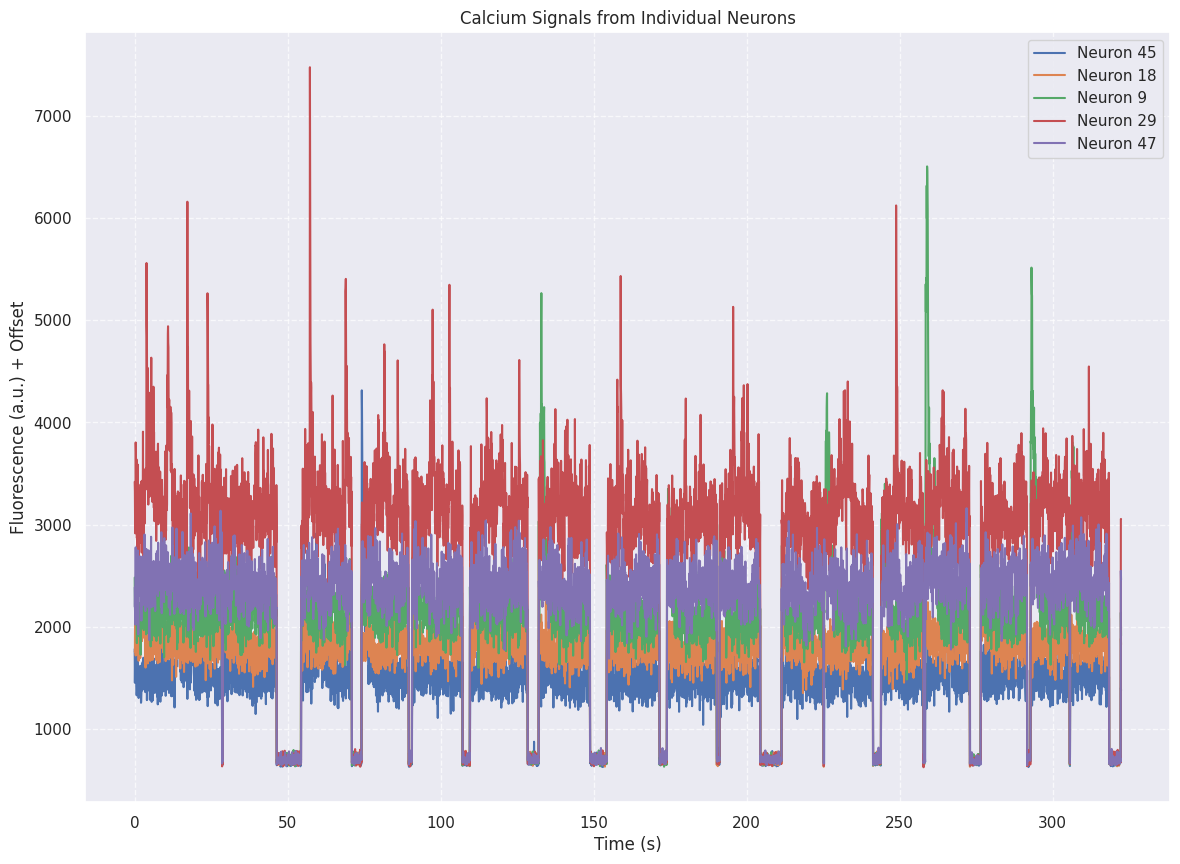

In [11]:
# Select a few cells to plot (cells with high confidence scores)
if iscell_data.shape[1] >= 2:
    # Sort by confidence score
    confidence_scores = iscell_data[:, 1]
    high_confidence_cells = np.argsort(confidence_scores)[-5:]  # Top 5 by confidence
else:
    # Just pick some cell indices
    high_confidence_cells = np.where(iscell_data[:, 0] > 0.5)[0][:5]

# Plot calcium signals for selected neurons
plt.figure(figsize=(14, 10))
for i, cell_idx in enumerate(high_confidence_cells):
    # Plot with an offset for clarity
    offset = i * 4
    plt.plot(timestamps_neural, fluorescence_data[:, cell_idx] + offset, 
             label=f'Neuron {cell_idx}')

plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.) + Offset')
plt.title('Calcium Signals from Individual Neurons')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The calcium signals show:

- Clear variations in activity across different neurons
- Some neurons show sharp transient increases in fluorescence, which likely represent calcium influx due to action potentials
- Different neurons have different baseline fluorescence levels and activity patterns
- Periodic dips in fluorescence might be related to behavioral events or motion artifacts

### Neural Activity Heatmap

Let's create a heatmap to visualize the activity of many neurons simultaneously.

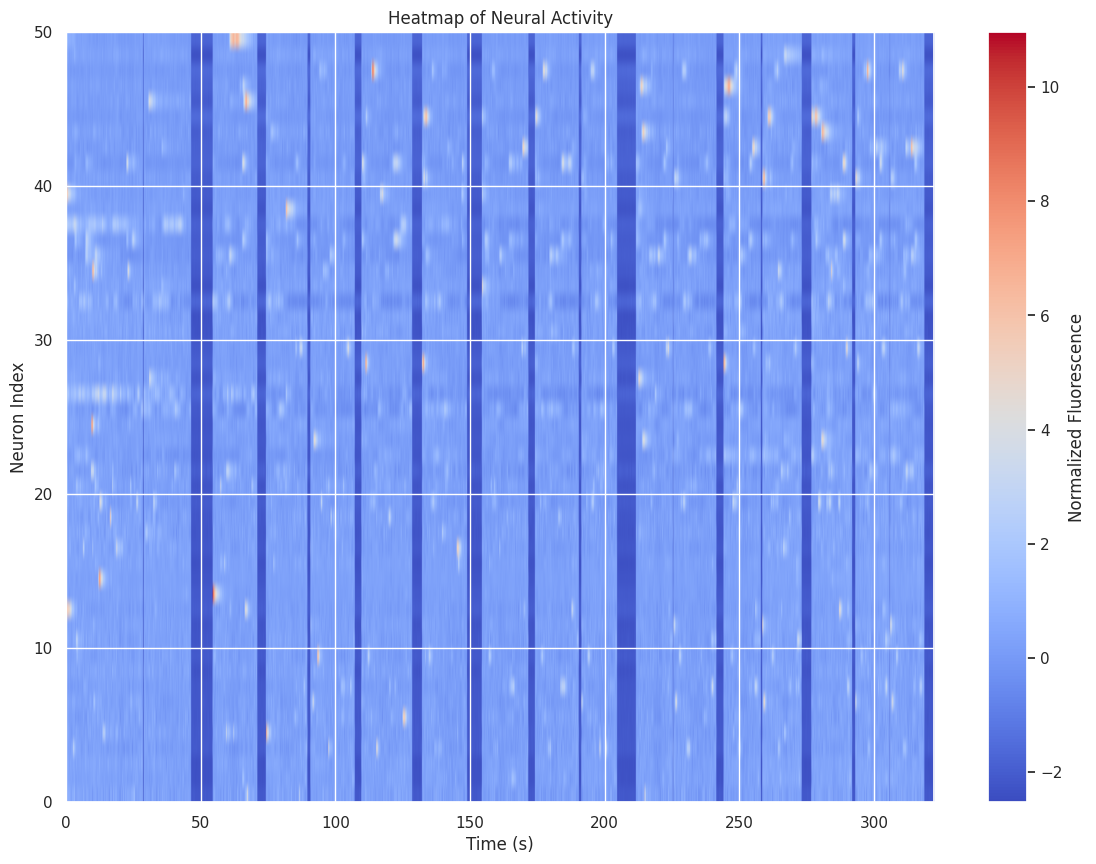

In [12]:
# Create a heatmap of neural activity
# Limit to first 50 neurons for better visualization
num_neurons_to_plot = min(50, fluorescence_data.shape[1])
neurons_to_plot = np.arange(num_neurons_to_plot)

# Normalize the data for better visualization
activity_data = fluorescence_data[:, neurons_to_plot]
activity_normalized = (activity_data - np.mean(activity_data, axis=0)) / np.std(activity_data, axis=0)

plt.figure(figsize=(14, 10))
plt.imshow(activity_normalized.T, aspect='auto', cmap='coolwarm',
           extent=[0, timestamps_neural[-1], 0, num_neurons_to_plot])
plt.colorbar(label='Normalized Fluorescence')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Heatmap of Neural Activity')
plt.show()

The neural activity heatmap reveals:

- Complex patterns of activity across the population of neurons
- Some neurons show correlated activity, while others have distinct patterns
- Vertical bands in the heatmap may indicate synchronous activity changes across many neurons in response to specific events
- The heterogeneity in activity patterns suggests different functional roles for different neurons

## Correlating Neural Activity with Behavior

Now let's investigate how neural activity relates to the animal's behavior. We'll align the calcium signals with behavioral variables like position and rewards.

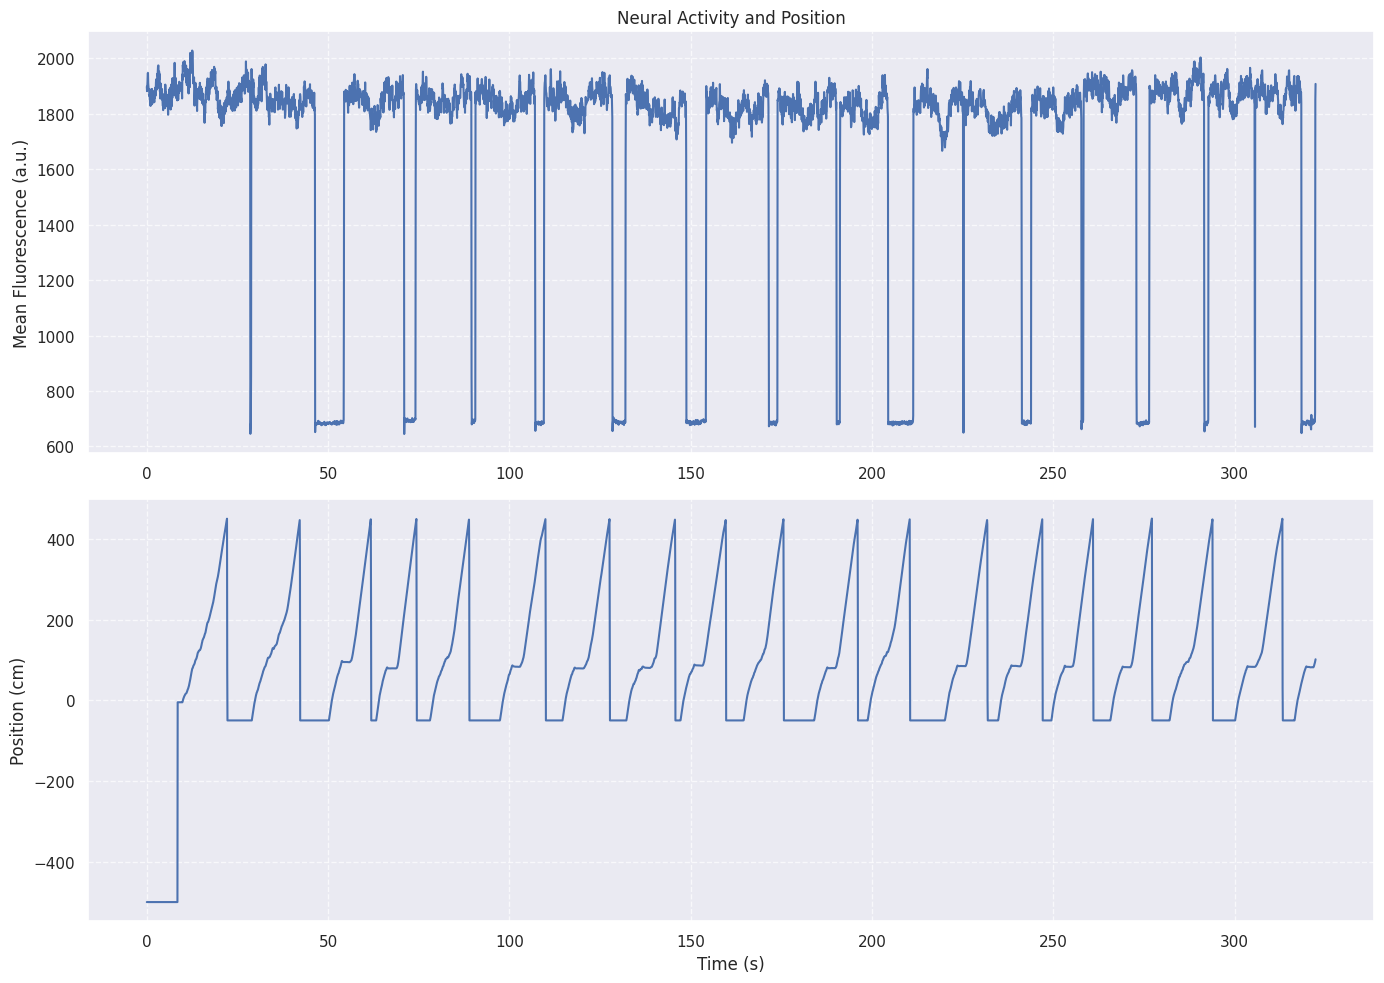

In [13]:
# Get a subset of behavioral data that matches our neural data timeframe
max_time_neural = timestamps_neural[-1]

position_mask = position_timestamps <= max_time_neural
position_subset = position_data[position_mask]
position_timestamps_subset = position_timestamps[position_mask]

# Calculate mean activity across all neurons
mean_activity = np.mean(fluorescence_data, axis=1)

# Plot neural activity aligned with position
plt.figure(figsize=(14, 10))

# Top plot: mean neural activity
plt.subplot(2, 1, 1)
plt.plot(timestamps_neural, mean_activity)
plt.ylabel('Mean Fluorescence (a.u.)')
plt.title('Neural Activity and Position')
plt.grid(True, linestyle='--', alpha=0.7)

# Bottom plot: position
plt.subplot(2, 1, 2)
plt.plot(position_timestamps_subset, position_subset)
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Position-Selective Neurons (Place Cells)

Let's look for neurons that might be selective for specific positions in the environment – these could be place cells.

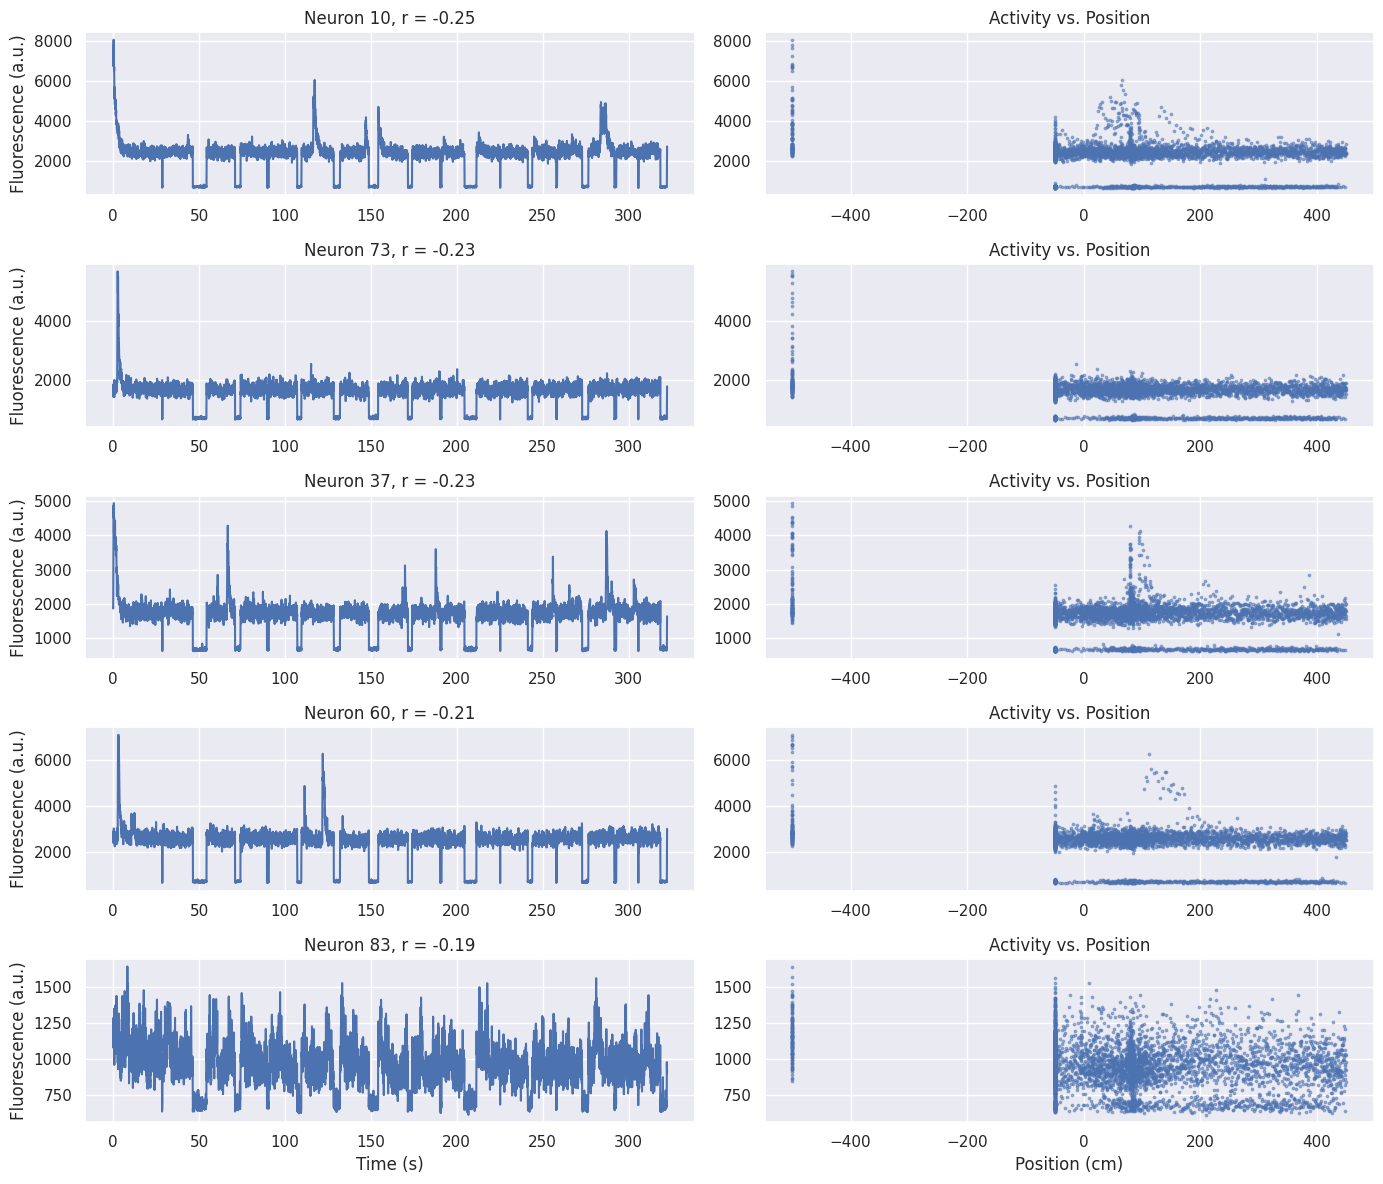

In [14]:
# For this analysis, we need to match neural timepoints with position timepoints
# We'll use a simple approach by finding the nearest position timepoint for each neural timepoint
matched_positions = np.zeros_like(timestamps_neural)

for i, t in enumerate(timestamps_neural):
    # Find the closest position timestamp
    idx = np.abs(position_timestamps - t).argmin()
    matched_positions[i] = position_data[idx]

# Calculate correlation between neural activity and position
# Limit to the first 100 neurons for computational efficiency
num_neurons_corr = min(100, fluorescence_data.shape[1])
position_correlations = np.zeros(num_neurons_corr)

for i in range(num_neurons_corr):
    position_correlations[i] = np.corrcoef(fluorescence_data[:, i], matched_positions)[0, 1]

# Find the neurons with the strongest positive and negative correlations
top_correlated = np.argsort(np.abs(position_correlations))[-5:][::-1]

# Plot the top position-correlated neurons
plt.figure(figsize=(14, 12))
for i, idx in enumerate(top_correlated):
    # Create a subplot grid with 2 columns
    row = i
    
    # Neural activity trace
    plt.subplot(5, 2, 2*row+1)
    plt.plot(timestamps_neural, fluorescence_data[:, idx])
    plt.title(f'Neuron {idx}, r = {position_correlations[idx]:.2f}')
    if row == 4:  # Only add xlabel for bottom row
        plt.xlabel('Time (s)')
    plt.ylabel('Fluorescence (a.u.)')
    
    # Scatter plot of activity vs position
    plt.subplot(5, 2, 2*row+2)
    plt.scatter(matched_positions, fluorescence_data[:, idx], s=3, alpha=0.5)
    plt.title(f'Activity vs. Position')
    if row == 4:  # Only add xlabel for bottom row
        plt.xlabel('Position (cm)')
    
plt.tight_layout()
plt.show()

### Visualizing Tuning Curves

Let's create position tuning curves for a few neurons to visualize how their activity varies with the animal's position.

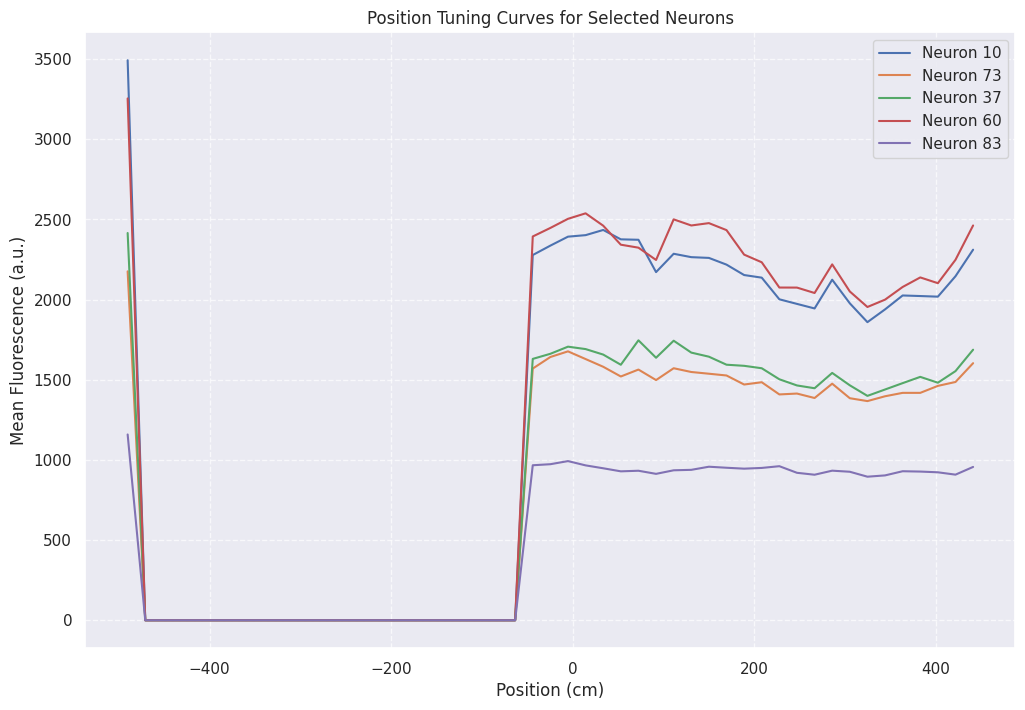

In [15]:
# Create position bins
position_bins = np.linspace(np.min(position_data), np.max(position_data), 50)
bin_centers = (position_bins[1:] + position_bins[:-1]) / 2
bin_indices = np.digitize(matched_positions, position_bins) - 1
bin_indices = np.clip(bin_indices, 0, len(bin_centers) - 1)

# Calculate tuning curves for top correlated neurons
tuning_curves = []
for idx in top_correlated:
    # Calculate mean activity in each position bin
    tuning_curve = np.zeros(len(bin_centers))
    for bin_idx in range(len(bin_centers)):
        mask = bin_indices == bin_idx
        if np.sum(mask) > 0:  # Ensure there are data points in this bin
            tuning_curve[bin_idx] = np.mean(fluorescence_data[:, idx][mask])
    tuning_curves.append(tuning_curve)

# Plot tuning curves
plt.figure(figsize=(12, 8))
for i, idx in enumerate(top_correlated):
    plt.plot(bin_centers, tuning_curves[i], label=f'Neuron {idx}')

plt.xlabel('Position (cm)')
plt.ylabel('Mean Fluorescence (a.u.)')
plt.title('Position Tuning Curves for Selected Neurons')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Summary and Conclusions

In this notebook, we've explored data from Dandiset 001361, which contains two-photon calcium imaging recordings from hippocampal area CA1 during a virtual navigation task. Our analysis reveals:

1. **Task Structure**:
   - Mice navigate in a linear virtual track, moving from start to end on repeated trials
   - Rewards are delivered at specific positions in the track
   - The task involves consistent navigation patterns with variations in speed and timing

2. **Neural Activity**:
   - Hippocampal CA1 neurons show diverse activity patterns during the task
   - Some neurons exhibit position selectivity, similar to classic place cells
   - The population as a whole shows complex encoding of spatial information
   - Neural activity is modulated by behavioral events like reward and teleportation

3. **Neural-Behavioral Relationships**:
   - Position information is encoded across multiple neurons
   - Some neurons show clear correlations with the animal's position in the virtual environment
   - Neural activity shows synchronous changes at certain behavioral events

This Dandiset provides a rich resource for studying how hippocampal neurons encode spatial information and how this coding relates to reward processing. The data support the paper's conclusion about flexible hippocampal coding of experience relative to reward.

## Future Directions

This notebook provides a starting point for exploring this Dandiset. Here are some potential directions for further analysis:

1. **Advanced Place Cell Analysis**:
   - Apply more sophisticated methods to identify and classify place cells
   - Analyze the stability of place fields across trials
   - Investigate remapping of place fields in response to reward location changes

2. **Trial-by-Trial Analysis**:
   - Compare neural activity across trials to study learning and adaptation
   - Examine how neural representations change with experience

3. **Reward Coding**:
   - Investigate neurons that respond specifically to reward delivery
   - Analyze how reward expectation is encoded before reward zones

4. **Population Coding**:
   - Apply dimensionality reduction techniques like PCA or t-SNE to study population dynamics
   - Develop decoders to predict position from neural activity

5. **Comparison Across Subjects**:
   - Compare neural coding across different mice in the dataset
   - Identify consistent coding principles across subjects

## References

- Sosa, M., Plitt, M. H., & Giocomo, L. M. (2025). A flexible hippocampal population code for experience relative to reward. *Nature Neuroscience*. [Dandiset 001361](https://doi.org/10.48324/dandi.001361/0.250406.0045)
- To explore this specific NWB file interactively online: [NWB on Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/&dandisetId=001361&dandisetVersion=0.250406.0045)